# English-French Translation with Seq2Seq Transformer

In [1]:
import sys

#  Add project directory
sys.path.append("..")

In [2]:
import torch
from model.transformer import TransformerSeq2Seq, TransformerEncoder, TransformerDecoder
from utils.loss import MaskedBCELoss
from utils.train import minibatch_gd

In [3]:
from data.engfra_trans import MTEngFra

## Initialize the dataset

In [4]:
# Dataset parameters
data_path = "../data"
num_steps = 10
num_train = 200
num_val = 50

In [5]:
dataset = MTEngFra(data_path, num_steps, num_train, num_val)

Dataset already downloaded and extracted.


In [6]:
# Test dataloader
for _, data in enumerate(dataset.data_loader(batch_size=2)):
    print(data)
    break

(tensor([[53, 11,  1,  2,  3,  3,  3,  3,  3,  3],
        [71, 21,  5,  2,  3,  3,  3,  3,  3,  3]]), tensor([[ 0, 89, 89, 11,  3,  4,  4,  4,  4,  4],
        [ 0, 89, 89,  2,  3,  4,  4,  4,  4,  4]]), tensor([[15, 27, 89,  2,  3,  4,  4,  4,  4,  4],
        [69, 89, 70,  2,  3,  4,  4,  4,  4,  4]]), tensor([4, 4]))


## Prepare the model and optimizers

In [12]:
# Hyperparameters for the Transformer
num_hiddens, enc_num_layers, dec_num_layers, dropout, batch_size = 32, 4, 8, 0.1, 32
enc_num_heads, dec_num_heads, ffn_num_hiddens = 8, 16, 64
src_vocab_size = len(dataset.src_vocab)
tgt_vocab_size = len(dataset.tgt_vocab)

# Hyperparameters for GD
lr = 0.001
num_epochs = 50

In [13]:
# Initialize the modules
encoder = TransformerEncoder(src_vocab_size, num_hiddens, enc_num_heads, enc_num_layers, ffn_num_hiddens, dropout)
decoder = TransformerDecoder(tgt_vocab_size, num_hiddens, dec_num_heads, dec_num_layers, ffn_num_hiddens, dropout)
model = TransformerSeq2Seq(encoder, decoder, dataset.tgt_vocab['<pad>'])

# Criterions and Optimizer
criterion = MaskedBCELoss(dataset.tgt_vocab['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr)

In [14]:
# Check the models
from torchinfo import summary

In [15]:
# Create a sample input to show the model structure
dummy_batch_size = 2
dummy_seq_length = 5
dummy_x = torch.randint(0, src_vocab_size, (dummy_batch_size, dummy_seq_length))
dummy_y = torch.randint(0, tgt_vocab_size, (dummy_batch_size, dummy_seq_length))
dummy_z = torch.tensor([1, 2])

# Display model summary
summary(model, 
        input_data=[dummy_x, dummy_y, dummy_z],
        col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
        depth=4,
        device='cpu')

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
TransformerSeq2Seq                                      [2, 5]                    [2, 5, 90]                --                        --                        --
├─TransformerEncoder: 1-1                               [2, 5]                    [2, 5, 32]                --                        --                        --
│    └─Embedding: 2-1                                   [2, 5]                    [2, 5, 32]                2,752                     --                        5,504
│    └─PositionalEncoding: 2-2                          [2, 5, 32]                [2, 5, 32]                --                        --                        --
│    └─Sequential: 2-3                                  --                        --                        --                        --                        --
│    │    └─

## Train the model

In [16]:
from time import perf_counter
device = torch.device("cudo:0" if torch.cuda.is_available() else "cpu")

In [17]:
start = perf_counter()
train_loss, val_loss = minibatch_gd(model, dataset, batch_size, criterion, optimizer, device, num_epochs)
end = perf_counter()
f'{end-start:.2f}s'

d:\Study Materials\PyTorch_ML_AI\Attention and Transformer\notebooks\..\model\attention.py:108: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  scores = torch.bmm(queries, keys.transpose(1, 2)) / torch.tensor(math.sqrt(d))  # (batch_size, num_queries, num_keys)
d:\Study Materials\PyTorch_ML_AI\Attention and Transformer\notebooks\..\model\attention.py:108: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  scores = torch.bmm(queries, keys.transpose(1, 2)) / torch.tensor(math.sqrt(d))  # (batch_size, num_queries, num_keys)


Epoch [1/50]
Epoch Average Loss: 0.1223
Validation Average Loss: 0.1167
Epoch [2/50]
Epoch Average Loss: 0.1059
Validation Average Loss: 0.1107
Epoch [3/50]
Epoch Average Loss: 0.1006
Validation Average Loss: 0.1094
Epoch [4/50]
Epoch Average Loss: 0.0965
Validation Average Loss: 0.1017
Epoch [5/50]
Epoch Average Loss: 0.0910
Validation Average Loss: 0.1113
Epoch [6/50]
Epoch Average Loss: 0.0877
Validation Average Loss: 0.1091
Epoch [7/50]
Epoch Average Loss: 0.0847
Validation Average Loss: 0.1088
Epoch [8/50]
Epoch Average Loss: 0.0811
Validation Average Loss: 0.1066
Epoch [9/50]
Epoch Average Loss: 0.0801
Validation Average Loss: 0.1092
Epoch [10/50]
Epoch Average Loss: 0.0785
Validation Average Loss: 0.1077
Epoch [11/50]
Epoch Average Loss: 0.0775
Validation Average Loss: 0.1097
Epoch [12/50]
Epoch Average Loss: 0.0757
Validation Average Loss: 0.1078
Epoch [13/50]
Epoch Average Loss: 0.0756
Validation Average Loss: 0.1174
Epoch [14/50]
Epoch Average Loss: 0.0735
Validation Average 

'59.89s'

## Plot losses and try to predict

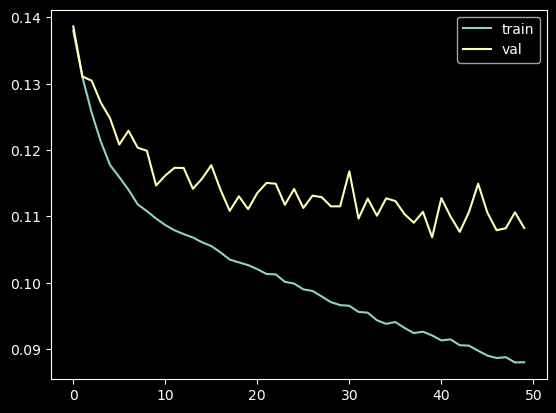

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.show()

In [24]:
# Reverse target vocab
rev_tgt_vocab = {}
for key in dataset.tgt_vocab:
    rev_tgt_vocab[dataset.tgt_vocab[key]] = key

In [31]:
# Try some prediction
# Tokenize example
english = ["go", "!"]
indices = []
for token in english:
    embed_index = dataset.src_vocab[token] if token in dataset.src_vocab else dataset.src_vocab["<unk>"]
    indices.append(embed_index)
tokens = torch.tensor(indices).reshape(1, -1)

# Predict
output, _ = model.predict(tokens, None, device, 10)
decoded_output = []
for idx in output.reshape(-1):
    decoded_output.append(rev_tgt_vocab[idx.item()])
" ".join(decoded_output)

'<eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>'